In [1]:
import pickle
import time
import numpy as np
import pandas as pd

import torch
import torchTools as tt

#import beamline
from beamline_29 import IEX

In [2]:
#import scaling
input_fn = 'IEX_100k_04w.pkl'

scaling_fn = input_fn.split('.')[0]+'_scaling.pkl'
with open(scaling_fn, 'rb') as f:
    scaling = pickle.load(f)

In [3]:
#import model
nn_fn = input_fn.split('.')[0]+'_NN_results.pkl'
with open(nn_fn, 'rb') as f:
    result = pickle.load(f)

In [4]:
len(result)

5

In [5]:
result[4].keys()

dict_keys(['model', 'loss', 'metric'])

In [6]:
result[4]['model']

MLModel(
  (inputLayer): Linear(in_features=12, out_features=12, bias=True)
  (hiddenLayers): ModuleList(
    (0): Linear(in_features=12, out_features=12, bias=True)
    (1): Linear(in_features=12, out_features=12, bias=True)
  )
  (outputLayer): Linear(in_features=12, out_features=1, bias=True)
)

In [7]:
#using 40% window for sampling
IEX.sRange = IEX.sRange * 0.4 # now at 0.4 of original
IEX.sRange

array([[[-8.160e+00,  8.160e+00],
        [-8.000e+00,  8.000e+00],
        [-6.000e-01,  6.000e-01],
        [-4.000e-03,  4.000e-03],
        [-2.480e-01,  2.480e-01],
        [-8.000e+00,  8.000e+00]],

       [[-9.160e+00,  9.160e+00],
        [-8.000e+00,  8.000e+00],
        [-1.000e+00,  1.000e+00],
        [-4.000e-03,  4.000e-03],
        [-7.200e-02,  7.200e-02],
        [-8.000e+00,  8.000e+00]],

       [[-6.440e+00,  6.440e+00],
        [-8.000e+00,  8.000e+00],
        [-3.600e-01,  3.600e-01],
        [-8.000e-03,  8.000e-03],
        [-1.480e-01,  1.480e-01],
        [-8.000e+00,  8.000e+00]],

       [[-5.440e+00,  5.440e+00],
        [-1.400e+00,  1.400e+00],
        [-4.000e-01,  4.000e-01],
        [-8.000e-03,  8.000e-03],
        [-1.400e-01,  1.400e-01],
        [-2.996e+00,  2.996e+00]],

       [[-3.320e+00,  3.320e+00],
        [-1.680e+01,  1.680e+01],
        [-2.000e+00,  2.000e+00],
        [-1.600e-01,  1.600e-01],
        [-1.288e+00,  1.288e+00],
      

In [8]:
#create beamline settings array (100-1000 configs)

Nconfigs = 1000
configs = []

configs = [IEX.sample().copy() for _ in range(Nconfigs)]

In [9]:
#run configs through shadow model and time it

shadow_results = []

t1 = time.time()
for i in range(Nconfigs):
    IEX.pos = configs[i]
    shadow_results.append(IEX.run())
t2 = time.time()
print(f'Duration: {t2 - t1}')

Duration: 653.005110502243


In [10]:
# Get model predictions
# 1. scale beamline settings for NN

#scale configs
t1 = time.time()

configs_masked = [config[IEX.mask == 1] for config in configs]
configs_array = np.asarray(configs_masked)
configs_pd = pd.DataFrame(configs_array, columns=['oe1x','oe1xrot','oe2x','oe2xrot','oe3xrot','oe4xrot','oe5y','oe5xrot','oe5yrot','oe6y','oe6xrot','oe6yrot',])
configFeatures = scaling.transform(configs_pd)
configFeatures = pd.DataFrame(configFeatures, columns=configs_pd.columns)

config_tensor = torch.tensor(configFeatures.values)


t2 = time.time()


print(f'Scaling duration: {t2 - t1}')
# 2. run scaled configs through model and time it


model = result[4]['model']
device = torch.device('cpu')
tt.to_device(model, device)

nn_results = model(tt.to_device(config_tensor.float(), device))

t3 = time.time()
print(f'Inference duration: {t3 - t2}')

Scaling duration: 0.004817008972167969
Inference duration: 0.036173343658447266


Inference is 10k times faster (at least for a 1k batch)

In [11]:
nn_results[0:10]

tensor([[19142.4648],
        [36241.0195],
        [47700.2812],
        [48419.4062],
        [41953.3828],
        [52039.2031],
        [79848.3672],
        [61503.8477],
        [47712.8203],
        [29493.7754]], grad_fn=<SliceBackward>)

In [12]:
shadow_results[0:10]

[19805, 35057, 47017, 49251, 41970, 53261, 80075, 61587, 47714, 29130]

#plot comparison of results
#shadow vs surrogate
#histogram for shadow, surrogate



In [13]:
diff = np.asarray(shadow_results) - nn_results.detach().numpy().reshape(Nconfigs,)

In [14]:
import matplotlib.pyplot as plt

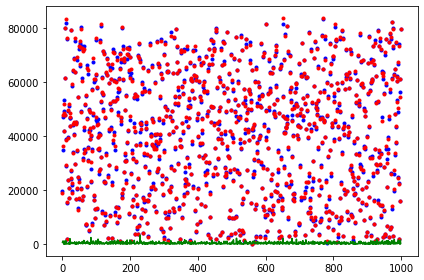

In [15]:
fig, axs = plt.subplots(1, 1, tight_layout=True)
axs.plot(shadow_results, linestyle = ' ', marker = '.', label = 'Shadow', color = 'blue')
axs.plot(nn_results.tolist(), linestyle = ' ', marker = '.', label = 'NN', color = 'red')

axs.plot(abs(diff), color = 'green', label = 'abs(diff)')

In [16]:
diff.max()

2228.625

In [17]:
diff.min()

-3339.10546875